# Calibration of Orbitrap deltas
1. Loads uncalibrated (external) deltas, identifies samples and standards by name
2. For isotopologues with multiple points of reference, runs an ensemble of multiple-point linear calibrations peturbed by SEM values of data and uncertainties of reference values.   
    For isotopologues with just one reference (e.g. clumps), uses a one-point calibration.
3. Calibrates orbitrap internal delta values.

## Input:
- An 'external_deltas_YYYY_MM_DD.csv' file for the sequence, produced by 'Orbitrap-bracketing'
- The start of sample and standard injection names
- Nitrate reference data 'nitrate_references.xlsx'

## Output:
- Calibration curves and uncertainties for each isotopologue
- Calibrated delta values for each sample


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Specify the path to csv internal deltas file
folder = 'data'
# Specify the path to reference data
ref_filename = 'references_nitrate.xlsx'

# Specify the start of the names of standards and samples
stds_startwith = ('NICO','USGS')
samples_startwith = ('ech','CDD','CdD','test')

datafiles = [string for string in os.listdir(folder)  if string.startswith('external_deltas_20')] 
if len(datafiles)==1:
    file = datafiles[0]
    print('Found data file at ' + folder+'/'+file )
elif len(datafiles)==0:
    print('Warning: found no data files at ' + folder )
else:
    file = datafiles[-1]
    print('Found multiple data files. Using ' + folder+'/'+file )

/Users/jacksaville/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Found data file at data/external_deltas_2024-03-19.csv


## 1. Load Orbitrap deltas and identify samples and standards
- Loads external delta csv file 
- Seperates samples and standards by name
- Import reference data 

In [3]:
# create calibrations folder
directory_path = os.path.join(folder,'calibration')
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' created.")
else:
    print(f"Directory '{directory_path}' already exists.")

# load results csv
df = pd.read_csv(os.path.join(folder,file)).drop(columns=['Unnamed: 0'])
print('Loaded results file ' + file )

# identify isotopologues
isotopologs = [iso.split('_')[-1] for iso in df.columns if iso.startswith('d')]

# seperate standards and samples
stds_df = df[df['sample_name'].str.startswith(stds_startwith) ]
samples_df = df[df['sample_name'].str.startswith(samples_startwith) ].sort_values(by='sample_name')

# function to average repeat injections of same sample
def summarise(df):


    means=['mean_'+iso for iso in isotopologs]
    sems=['err_'+iso for iso in isotopologs]

    stats=pd.DataFrame()
    stats['sample_name']=df.groupby('sample_name')[isotopologs].mean().reset_index()['sample_name']
    stats[means]=df.groupby('sample_name')[isotopologs].mean().reset_index()[isotopologs]
    stats[sems]=df.groupby('sample_name')[isotopologs].sem().reset_index()[isotopologs]
    
    return stats.sort_values(by='sample_name')

# Contain mean and sem deltas of each sample
stds_stats = summarise(stds_df)
print('Identified '+str(len(stds_stats))+' standards: '+str(list(stds_stats['sample_name'])))
samples_stats = summarise(samples_df)
print('Identified '+str(len(samples_stats))+' samples: '+str(list(samples_stats['sample_name'])))

Directory 'data/calibration' created.
Loaded results file external_deltas_2024-03-19.csv
Identified 3 standards: ['NICO6', 'USGS34', 'USGS35']
Identified 10 samples: ['CDD-280', 'CDD-281', 'CDD-282', 'CDD-283', 'CDD-284', 'CDD-285', 'CDD-286', 'CDD-287', 'CDD-288', 'CDD-289']


### Identify standards
1. Verify deltas of non-dried standard are correct.
2. Rename as 'USGS34', 'NICO6' etc using the dictionary 'nn'.

In [5]:
# Specify renaming: all other rows will be ignored
nn = {'NICO6':'NICO6', 'USGS34':'USGS34', 'USGS35':'USGS35' }

# filtered df with only renames rows in
stds_fstats=pd.DataFrame(columns = stds_stats.columns, index=stds_stats.index)
# copy for new names
stds_nstats=stds_stats.copy()

for oldname, newname in nn.items():
    for i, name in enumerate(stds_stats['sample_name']):
        if name == oldname:
            stds_nstats.loc[i,'sample_name'] = newname
            print('Renamed '+oldname+' as '+newname)
            stds_fstats.iloc[i] = stds_nstats.iloc[i]
            
stds_fstats=stds_fstats.dropna(how='all').copy().reset_index(drop=True)
stds_fstats.head(10)

Renamed NICO6 as NICO6
Renamed USGS34 as USGS34
Renamed USGS35 as USGS35


,sample_name,mean_d15N,mean_d17O,mean_d18O,err_d15N,err_d17O,err_d18O
0,NICO6,0.035595,0.017666,0.036477,0.000342,0.00071,0.000202
1,USGS34,0.001233,-0.012837,-0.022685,0.000502,0.000584,0.000269
2,USGS35,0.004867,0.052345,0.060244,0.000451,0.000474,0.000224


### Import reference data from 'references_nitrate.xlsx'

In [6]:
# Reference delta values and errors for calibration
references = pd.read_excel('references_nitrate.xlsx')
refs_stats = references[references['sample_name'].isin(stds_fstats['sample_name'])].sort_values(by='sample_name').reset_index(drop=True)
refs_stats.iloc[:,1:]=refs_stats.iloc[:,1:].copy().copy()*1e-3
refs_stats.head()

,sample_name,mean_d15N,mean_d17O,mean_d18O,mean_d15N18O,mean_d17O18O,mean_d18O18O,err_d15N,err_d17O,err_d18O,err_d15N18O,err_d17O18O,err_d18O18O
0,NICO6,0.0337,NaN,0.03287,NaN,NaN,NaN,0.0003,NaN,0.0003,NaN,NaN,NaN
1,USGS34,-0.0018,-0.0148,-0.02790,NaN,NaN,NaN,0.0003,0.0003,0.0003,NaN,NaN,NaN
2,USGS35,0.0027,0.0515,0.05750,0.060355,0.091808,0.098037,0.0003,0.0003,0.0003,0.000424,0.000361,0.000361


### Identify samples
Rename Col du Dôme samples as 'CDD-202' etc 

In [7]:
oldnames = samples_stats['sample_name']
newnames = ['CDD-' + n.split(' ')[-1] for n in oldnames if n.startswith('ech')]
nn = dict(zip(oldnames, newnames))

# Rename as per nn
for oldname, newname in nn.items():
    for i, name in enumerate(samples_stats['sample_name']):
        if name == oldname:
            samples_stats.loc[i,'sample_name'] = newname
            
samples_stats.head(20)

,sample_name,mean_d15N,mean_d17O,mean_d18O,err_d15N,err_d17O,err_d18O
0,CDD-280,0.001572,0.048815,0.060346,0.000537,0.000858,0.000233
1,CDD-281,0.005685,0.056577,0.068357,0.000599,0.000447,0.000258
2,CDD-282,0.004835,0.053035,0.063967,0.000194,0.001431,0.000325
3,CDD-283,-0.001287,0.053074,0.059692,0.000457,0.000705,0.000456
4,CDD-284,0.005845,0.053858,0.065205,0.000423,0.000729,0.000416
5,CDD-285,0.006085,0.058875,0.069169,0.000387,0.000891,0.000474
6,CDD-286,0.003424,0.057123,0.066563,0.000563,0.000904,0.000331
7,CDD-287,0.002958,0.051058,0.061245,0.000576,0.000481,0.000190
8,CDD-288,0.002571,0.054296,0.061353,0.000457,0.000709,0.000417
9,CDD-289,0.003678,0.059210,0.070227,0.000557,0.000965,0.000226


## 2. Define a delta scale calibration using dried standards

For the isotopologues with multiple reference points:
- Many iterations of linear regression, each peturbed by the errors on Orbitrap standard deltas and reference data. 

For the isotopologues with a single reference point:
 - One point calibration (gradient forced to one).  
 
Mean and SEM of 'true deltas' are recorded for each 'measured delta'.  
Calibration curves and their uncertainty are plotted. Calibration data are saved in 'calibration_YYYY-MM-DD.csv'.  


Linear regression caibration for 15N
Linear regression caibration for 17O
Linear regression caibration for 18O


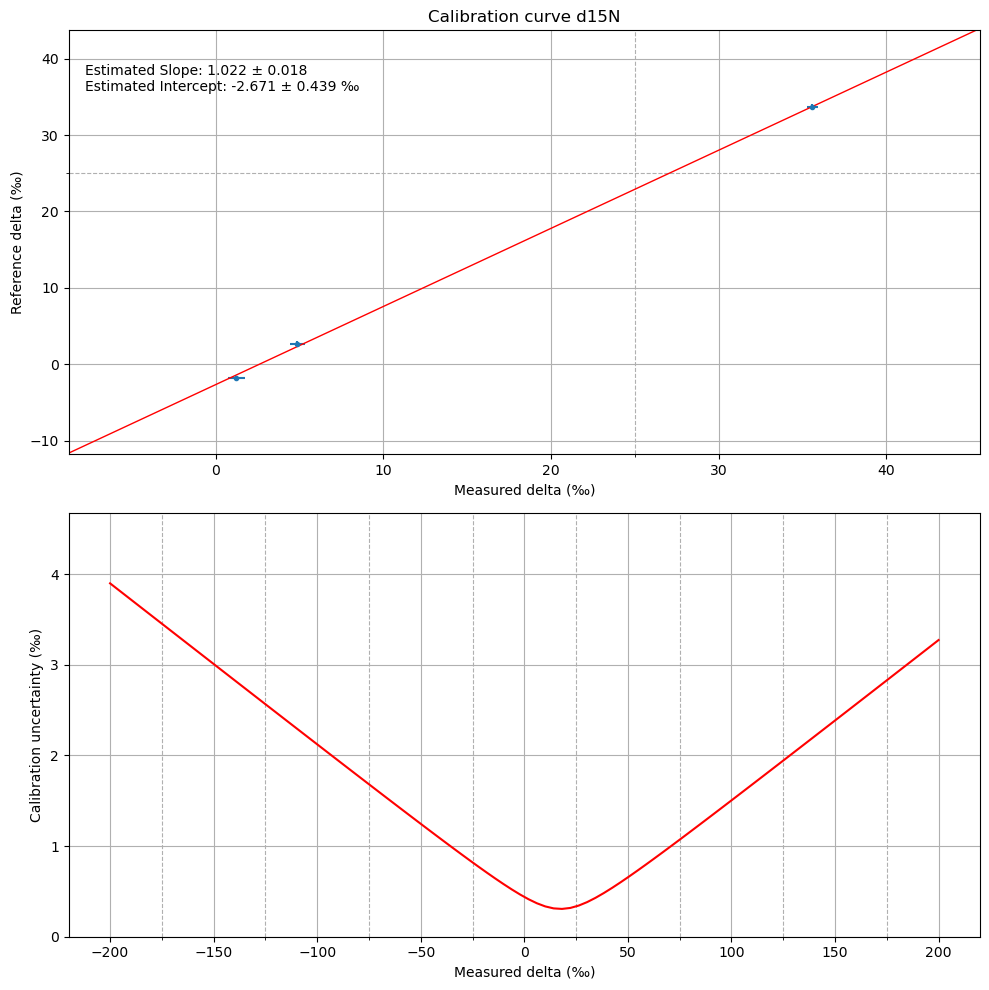

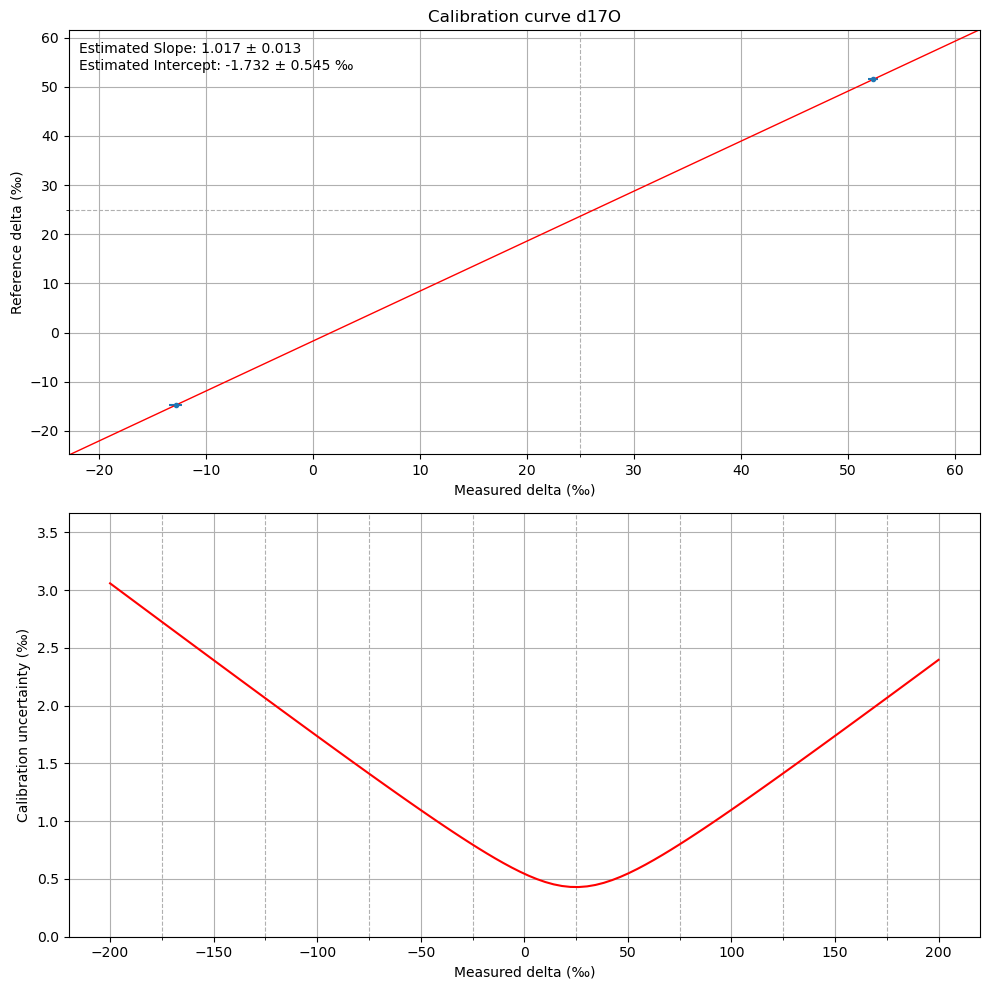

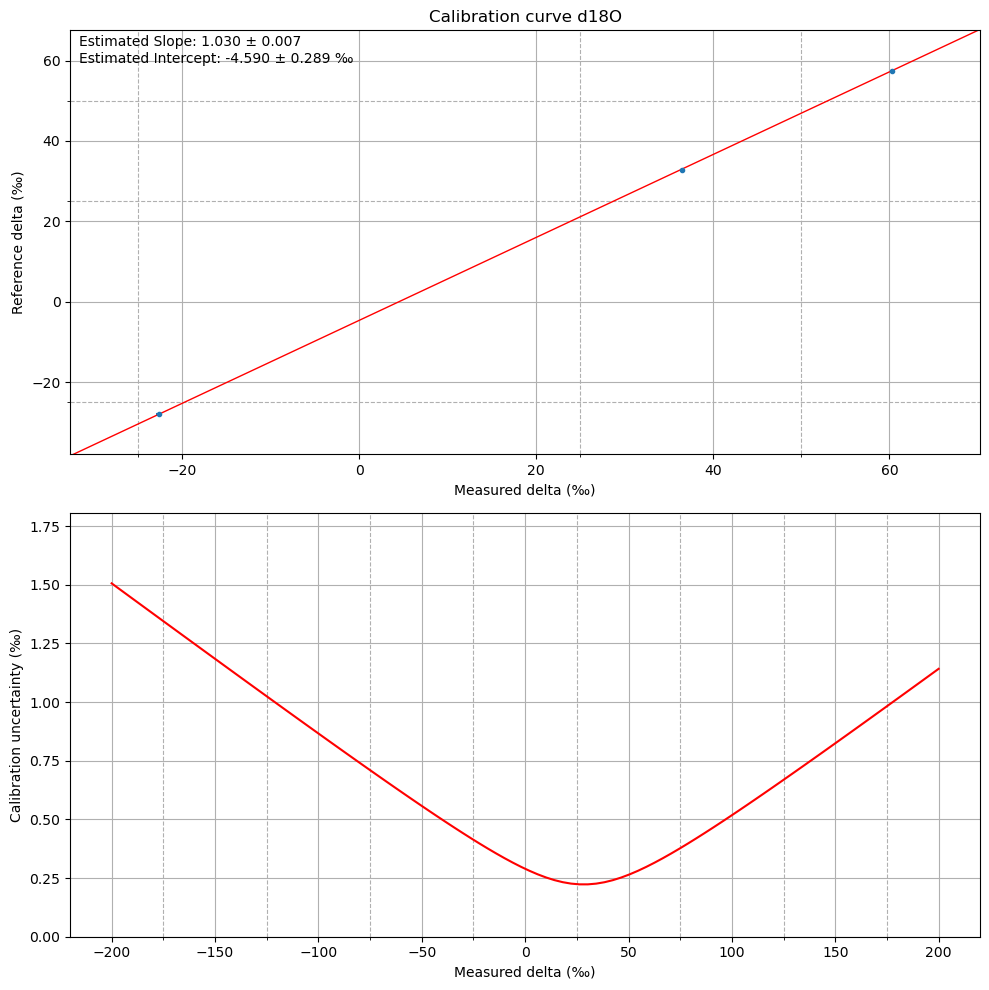

In [8]:
# Linear calibration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime
current_datetime = datetime.now()
current_date_string = current_datetime.strftime("%Y-%m-%d")

# Number of iterations for perturbation
num_iterations = 1000
#  delta points to calculate calibration at
n_points = 100
delta_range = [-200e-3,200e-3]
delta_meas=np.linspace(delta_range[0],delta_range[1],n_points)


# Create a DF with calibrations for all isotoplogues
isotopelist = [iso.split('_')[1][1:] for iso in samples_stats.columns if iso.startswith('mean_d')]
calibrations = pd.DataFrame(columns=['delta_meas']+['d'+iso+'_true' for iso in isotopelist]+['d'+iso+'_err' for iso in isotopelist],index=range(n_points))
calibrations['delta_meas'] = delta_meas

for isotope in isotopelist:
    
    # For singly-substituted
    if len(isotope)==3:
    
        common_stds = [std for std in stds_fstats['sample_name'] if std in list(refs_stats['sample_name'])]

        xx = stds_fstats[refs_stats[refs_stats['sample_name'].isin(common_stds)]['mean_d'+isotope].notna()]['mean_d'+isotope]
        dx = stds_fstats[refs_stats[refs_stats['sample_name'].isin(common_stds)]['mean_d'+isotope].notna()]['err_d'+isotope]
        yy = refs_stats[refs_stats[refs_stats['sample_name'].isin(common_stds)]['mean_d'+isotope].notna()]['mean_d'+isotope]
        dy = refs_stats[refs_stats[refs_stats['sample_name'].isin(common_stds)]['mean_d'+isotope].notna()]['err_d'+isotope]

    # Lists to store the results of each iteration
        slope_values = []
        intercept_values = []
        calib_values = np.zeros([n_points, num_iterations])

    #   Peturb deltas by their uncertainty 
        for n in range(num_iterations):
            # Perturb x and y based on their Gaussian uncertainties
            perturbed_y = np.random.normal(yy, dy)
            perturbed_x = np.random.normal(xx, dx)

            # Perform linear regression on the perturbed data
            model = LinearRegression()
            model.fit(perturbed_x.reshape(-1, 1), perturbed_y)

            # Get the slope and intercept of the regression line for the perturbed data
            slope_values.append(model.coef_[0])
            intercept_values.append(model.intercept_)

            calib_values[:,n] = model.predict(delta_meas.reshape(-1, 1))

        # Calculate and save calibration stats
        calib_values = pd.DataFrame(calib_values)
        delta_true_mean = calib_values.mean(axis=1)
        delta_true_err = calib_values.std(axis=1)
        calibrations['d'+isotope+'_true'] = delta_true_mean
        calibrations['d'+isotope+'_err'] = delta_true_err


        # Calculate the mean and standard deviation of the obtained slope and intercept values
        mean_slope = np.mean(slope_values)
        std_slope = np.std(slope_values)
        mean_intercept = np.mean(intercept_values)
        std_intercept = np.std(intercept_values)

        # Plot the calibration curve and distribution of slope and intercept values
        print('Linear regression caibration for '+isotope)
        plt.figure(figsize=(10,10))

        plt.subplot(2,1,1)
        plt.errorbar(xx*1e3,yy*1e3,
                     xerr=dx*1e3, yerr=dy*1e3,
                     fmt='.', label='Data Points')
        plt.plot(delta_meas*1e3, delta_true_mean*1e3, color='red', label='Weighted Linear Regression',lw=1)
        plt.xlabel('Measured delta (‰)')
        plt.ylabel('Reference delta (‰)')
        plt.title('Calibration curve d'+isotope)
        plt.xlim([np.min(xx)*1e3-10,np.max(xx)*1e3+10])
        plt.ylim([np.min(yy)*1e3-10,np.max(yy)*1e3+10])
        plt.text(np.min(xx*1e3-9),np.max(yy*1e3+2), f"Estimated Slope: {mean_slope:.3f} ± {std_slope:.3f}\nEstimated Intercept: {mean_intercept*1e3:.3f} ± {std_intercept*1e3:.3f} ‰")
        plt.gca().yaxis.set_minor_locator(MultipleLocator(25))
        plt.gca().xaxis.set_minor_locator(MultipleLocator(25))
        plt.grid()
        plt.grid(which='minor',linestyle='--')

        plt.subplot(2,1,2)
        plt.plot(delta_meas*1e3, delta_true_err*1e3, color='red', label='Uncertainty')
        plt.xlabel('Measured delta (‰)')
        plt.ylabel('Calibration uncertainty (‰)')
        plt.ylim([0,1.2*np.max(delta_true_err)*1e3])
        plt.gca().xaxis.set_minor_locator(MultipleLocator(25))
        plt.grid()
        plt.grid(which='minor',linestyle='--')

        plt.tight_layout()

        plt.gcf().savefig(os.path.join(folder,'calibration','_'.join(['calibration_curve',isotope,current_date_string,'.png'])));
        
    # For doubly-substituted     
    if len(isotope)==6:
        
#         do a one-point calibration with USGS35 ± error
        # identify the standard with ref values
        common_std = [std for std in stds_fstats['sample_name'] if std in list(refs_stats['sample_name']) and ~np.isnan(refs_stats[refs_stats['sample_name']==std].reset_index(drop=True).loc[0,'mean_d'+isotope] )][0]
        ref_val = refs_stats[refs_stats['sample_name']==common_std]['mean_d'+isotope]
        ref_err = refs_stats[refs_stats['sample_name']==common_std]['err_d'+isotope]
        meas_val = stds_fstats[stds_fstats['sample_name']==common_std]['mean_d'+isotope]
        meas_err = stds_fstats[stds_fstats['sample_name']==common_std]['err_d'+isotope]
        # check for nan in measurements
        if len(meas_val.dropna())==1:
            # (1+ true delta) = (1 + measured delta) *  (1 + reference USGS35) / (1 + measured USGS35) 
            # equivalently: r_sam/r_ref = r_sam/r_internal *   r_USGS35 * r_internal / r_USGS * r_ref
            corr_factor = (1+ref_val)/(1+meas_val)
            corr_factor = corr_factor.iloc[0]
            
            delta_true_mean = corr_factor * (1 + delta_meas) -1
            delta_true_err = np.array([( ref_err.iloc[0]**2 + meas_err.iloc[0]**2 )**0.5]*len(delta_true_mean))
            
            calibrations['d'+isotope+'_true'] = delta_true_mean
            calibrations['d'+isotope+'_err'] = delta_true_err
            
            # Plot the calibration curve and distribution of slope and intercept values
            print('One-point caibration for '+isotope)
            plt.figure(figsize=(10,10))

            plt.subplot(2,1,1)
            plt.errorbar(meas_val*1e3,ref_val*1e3,
                         xerr = meas_err*1e3, yerr = ref_err*1e3,
                         fmt='.', label='Data Points')
            plt.plot(delta_meas*1e3, delta_true_mean*1e3, color='red', label='Weighted Linear Regression',lw=1)
            plt.xlabel('Measured delta (‰)')
            plt.ylabel('Reference delta (‰)')
            plt.title('Calibration curve d'+isotope)
            intercept = calibrations.loc[(calibrations['delta_meas']).abs().idxmin(),'d'+isotope+'_true']
            intercept_err = calibrations.loc[(calibrations['delta_meas']).abs().idxmin(),'d'+isotope+'_err']
            plt.text(np.min(delta_meas*1e3),0.9*np.max(delta_true_mean*1e3), f"Fixed Slope: 1.00 \nIntercept: {intercept*1e3:.3f} ‰ ")
            plt.gca().yaxis.set_minor_locator(MultipleLocator(25))
            plt.gca().xaxis.set_minor_locator(MultipleLocator(25))
            plt.grid()
            plt.grid(which='minor',linestyle='--')

            plt.subplot(2,1,2)
            plt.plot(delta_meas*1e3, delta_true_err*1e3, color='red', label='Uncertainty')
            plt.xlabel('Measured delta (‰)')
            plt.ylabel('Calibration uncertainty (‰)')
            plt.ylim([0,1.2*np.max(delta_true_err)*1e3])
            plt.gca().xaxis.set_minor_locator(MultipleLocator(25))
            plt.grid()
            plt.grid(which='minor',linestyle='--')

            plt.tight_layout()

            plt.gcf().savefig(os.path.join(folder,'calibration','_'.join(['calibration_curve',isotope,current_date_string,'.png'])));

        else:
            print('No calibration data found for '+isotope)

# EXPORT
calibrations.to_csv(os.path.join(folder,'calibration',''.join(['calibration_',current_date_string,'.csv'])))

    
    

## 3. Apply calibration to samples

In [9]:
#  CORRECTION of deltas using calibration curves

samples_corrected = samples_stats.copy()

# identify just those for which calibrations have been made
calibrated_isotopologues = [col.split('_')[0][1:] for col in calibrations.dropna(axis=1).columns if col.endswith('_true')]

for isotope in calibrated_isotopologues:
  
    delta_corrected = np.interp(samples_stats['mean_d'+isotope],calibrations['delta_meas'],calibrations['d'+isotope+'_true'])
    calib_err = np.interp(samples_stats['mean_d'+isotope],calibrations['delta_meas'],calibrations['d'+isotope+'_err'])
    err_corrected = np.sqrt( samples_stats['err_d'+isotope]**2 + calib_err**2)

    samples_corrected['mean_d'+isotope] = delta_corrected
    samples_corrected['err_d'+isotope]=err_corrected
    
samples_corrected.index=samples_corrected['sample_name']
samples_corrected.drop('sample_name',axis=1,inplace=True)
# EXPORT
samples_corrected.to_csv(os.path.join(folder,''.join(['calibrated_deltas_',current_date_string,'.csv'])))
# display
print('Samples calibrated for '+str(calibrated_isotopologues)+ 
      '\nDelta values saved as '+ os.path.join(folder,''.join(['calibrated_deltas_',current_date_string,'.csv']))
     )
samples_corrected

Samples calibrated for ['15N', '17O', '18O']
Delta values saved as data/calibrated_deltas_2024-03-19.csv


,mean_d15N,mean_d17O,mean_d18O,err_d15N,err_d17O,err_d18O
sample_name,,,,,,
CDD-280,-0.001063,0.047906,0.057540,0.000681,0.001013,0.000385
CDD-281,0.003142,0.055798,0.065787,0.000706,0.000753,0.000430
CDD-282,0.002273,0.052196,0.061267,0.000429,0.001542,0.000457
CDD-283,-0.003986,0.052236,0.056866,0.000645,0.000909,0.000547
CDD-284,0.003305,0.053033,0.062542,0.000563,0.000932,0.000530
CDD-285,0.003551,0.058135,0.066623,0.000535,0.001090,0.000588
CDD-286,0.000831,0.056353,0.063940,0.000690,0.001091,0.000471
CDD-287,0.000354,0.050186,0.058465,0.000703,0.000735,0.000363
CDD-288,-0.000042,0.053479,0.058576,0.000613,0.000918,0.000520
